# Getting insights about refrigeration leaks

**Table of contents**
- Overview
- Setup
  - Get Token
- Utility Functions
    - Accepted input values
- Use Case Implementation
  - Querying for the refrigeration use case
  - Exploratory Data Analysis
- Related Links

## Overview


APIs that are used in this sample: **IBM Environmental Intelligence - Greenhouse Gas (GHG) Emissions - Fugitive Emissions API**

You can calculate fugitive emissions and do a downstream analysis of fugitive emissions for organizations that operate large-scale and geographically-diverse refrigeration assets. These types of assets are fairly common in the food processing industry. The API requires the type of refrigerant and its consumption.

**Business value**

By leveraging these calculations, organizations can make data-driven decisions about refrigeration assets and their corresponding environmental impact.

**Use Case**

In this notebook, an example dataset of refrigeration assets will be used to demonstrate how the fugitive emissions API can get useful insights for an organization.


## Setup


Ensure that Python is installed in your system. Python 3+ is required.


<b>Note:</b> To run this notebook seamlessly, you must first configure your credentials for GHG Emission APIs in a file named `secrets.ini` in the following format:

```
[EI]
api.api_key = <Your GHG APIs API key>
api.client_id = <Your GHG APIs client Id>
```

Keep the secrets.ini file at an appropriate relative location of this notebook, for example, as specified in this config:

```config.read('../../../auth/secrets.ini')```

In [2]:
## Imports required for the notebook
# Install the packages below using pip/pip3 based on your python version.
#!pip install pandas configparser IPython geopy tqdm openpyxl matplotlib
import configparser
import pandas as pd
import numpy as np
import requests
import json
import time
from tqdm import tqdm
from geopy.geocoders import Nominatim

### Get token


Run the following code snippet to generate the Auth Bearer Token by using your api_key configured in secrets.ini.

In [3]:


config = configparser.RawConfigParser()
config.read(['../../../auth/secrets.ini','../../../auth/config.ini'])

EI_API_KEY      = config.get('EI', 'api.api_key')
EI_CLIENT_ID    = config.get('EI', 'api.client_id')
EI_AUTH_ENPOINT = config.get('EI', 'api.auth_endpoint')
EI_BASE_URL     = config.get('EI', 'api.base_url')

def get_bearer_token(token):
    headers = {
        'Content-Type': 'application/json',
        'cache-control': 'no-cache',
    }
    data = {"apiKey":token, "clientId":EI_CLIENT_ID}
    bearer_token_req = requests.post(EI_AUTH_ENPOINT, headers=headers, data= json.dumps(data))
    if bearer_token_req.status_code != 200:
        print( "Error in getting Bearer token. Error code : ",bearer_token_req.status_code)
    return bearer_token_req.json()['access_token']

mybearer_token = get_bearer_token(EI_API_KEY)

## Utility Functions


The following utility functions will be defined to help load, format, and submit data to the Fugitive Emissions API:

- ```read_excel_file```: Reads the input Excel file and performs data formatting
- ```geo_coder```: Converts geolocation to address
- ```create_payload```: Converts dict or dataframe-row to json format expected by the API
- ```get_fugitive_emission_from_api```: Queries the API with a given payload and returns the CO2e

In [4]:
def read_excel_file(excel_path, sheet_name):
    """
    Reads the input excel file and performs data formatting
    args:
        excel_path: Path to the input spreadsheet file or a file like object
        sheet_name: Sheet name to be read if there are multiple sheets
    """

    ## Read the excel file
    if sheet_name:
        data_orig_df = pd.read_excel(excel_path, sheet_name, header=[0,1],engine='openpyxl')  
    else:
        data_orig_df = pd.read_excel(excel_path, header=[0,1],engine='openpyxl')
    

    data_df = pd.DataFrame()

    ## process columns which require flatenning
    column_dict = {}
    column_dict['organisation'          ] = data_orig_df['Organisation'          ].columns
    column_dict['geo_coordinates'       ] = data_orig_df['Geo-coordinates'       ].columns
    column_dict['static_parameters'     ] = data_orig_df['Static parameters'     ].columns
    column_dict['operational_parameters'] = data_orig_df['Operational parameters'].columns
    column_dict['timestamp'             ] = data_orig_df['Timestamp'             ].columns

    data_df[column_dict['organisation'          ]] = data_orig_df['Organisation'          ][column_dict['organisation'          ]]
    data_df[column_dict['geo_coordinates'       ]] = data_orig_df['Geo-coordinates'       ][column_dict['geo_coordinates'       ]]
    data_df[column_dict['static_parameters'     ]] = data_orig_df['Static parameters'     ][column_dict['static_parameters'     ]]
    data_df[column_dict['operational_parameters']] = data_orig_df['Operational parameters'][column_dict['operational_parameters']]
    data_df[column_dict['timestamp'             ]] = data_orig_df['Timestamp'             ][column_dict['timestamp'             ]]

    ## Process/copy remaining columns that do not require flattening
    data_df['Asset id'            ] = data_orig_df['Asset id'            ] ## Keeping the asset id column name same
    data_df['asset_type'          ] = data_orig_df['Asset type'          ]
    data_df['Type'                ] = data_orig_df['Commodity type'      ]
#     data_df['commodity_usage'     ] = data_orig_df['Commodity Usage'     ]
    data_df['Consumption Quantity'] = data_orig_df['Consumption Quantity']
    data_df['Unit'                ] = data_orig_df['Consumption unit'    ]

    data_df['Asset id'] = data_df['Asset id'].apply(str)
    if 'Emission' in data_orig_df.columns:
        data_df[['emission']] = data_orig_df[['Emission']].values
    
    return data_df

#reading refrigeration data(location,type etc)
read_excel_file('./refrigeration_leaks_insights.xlsx', 'Sheet1').head(3)

    

,Level 0,Level 1,Level 2,Lat,Long,Cap,GWP,Age,leak%,Start Date (YYYY-MM-DD),End Date (YYYY-MM-DD),Asset id,asset_type,Type,Consumption Quantity,Unit
0,name1,FOOD STORAGE,USA,42.93,-93.48,3900,1.273,19,25.25,2024-04-11,2025-04-11,14201,Refrigeration,R-448A,897.6,kilogram
1,name1,FOOD STORAGE,USA,33.87,-95.23,3600,0.573,5,14.18,2024-04-12,2025-04-12,14202,Refrigeration,R-513A,502.2,kilogram
2,name1,FOOD STORAGE,USA,48.34,-95.43,3800,2.235,15,22.81,2024-04-13,2025-04-13,14203,Refrigeration,R-507A,825.1,kilogram


In [5]:
def geo_coder(lat, long):
    """
    Converts geolocation to address
    args: 
        lat: lattitue of the location
        long: longitute og the location
        
    returns:
        country, state, city, zipcode
    """
    geolocator = Nominatim(user_agent="geolocation_identifier_function")
    location   = geolocator.reverse(str(lat)+","+str(long),language='en')
    try:
        address    = location.raw["address"]
    except:
        address={}
        print((lat, long))
    
    country  = address['country' ] if 'country'  in address else None
    state    = address['state'   ] if 'state'    in address else None
    city     = address['city'    ] if 'city'     in address else None
    
    if 'postcode' not in address: zipcode = None
    else:
        zipcode = address["postcode"].split(':')[0] # use only first part of zipcode
        if ' ' in zipcode: zipcode = zipcode.split(' ')[-1] # ignore the state code and use the last part of zipcode
        if '-' in zipcode: zipcode = zipcode.split('-')[0]  # use only first part of zipcode
           
    return (country, state, city, zipcode)


In [6]:
def create_payload(data):
    """
    Converts dict or a row of dataframe to json fromat accepted by the API
    args:
        data: python dict or dataframe row
    returns:
        payload: json fromat accepted by the API
    """
    
    ## Convert lat-long to address for payload["location"]
    country, state, city, zipcode = geo_coder(data["Lat"], data["Long"])
    
    ## extract year, month for payload["timePeriod"]
    year  = data["Start Date (YYYY-MM-DD)"].year
    month = data["Start Date (YYYY-MM-DD)"].month
    
    ## create the JSON
    payload = {}
    payload["customID"        ] = {          "id": data["Asset id"]}
    payload["onBehalfOfClient"] = {   "companyId": "NA",     "companyName": data["Level 0"]}
    payload["organisation"    ] = {"departmentId": "NA",  "departmentName": data["Level 1"]}
    payload["requestType"     ] = "Actual"
    payload["location"        ] = {"country": country, "stateProvince": state, "zipPostCode": zipcode, "city": city}
    payload["site"            ] = {"siteId": "NA", "siteName": "NA", "buildingId": "NA","buildingName": "NA"}
    payload["timePeriod"      ] = {"year": year, "month": month}
    
    payload["activityData"    ] = {"refrigerantName":                data["Type"],
                                   "refrigerantInventoryBeginning":  str(data["Cap"]),
                                   "refrigerantInventoryEnd":        str(data["Cap"] - data["Consumption Quantity"]),
                                   "refrigerantsPurchasedFromProducers": "0",
                                   "refrigerantsProvidedByManufacturers": "0",
                                   "refrigerantsAddedToEquipment": "0",
                                   "refrigerantReturnedAfterRecycling": "0",
                                   "refrigerantSales": "0",
                                   "refrigerantLeftInEquipment": "0",
                                   "refrigerantReturnedToSuppliers": "0",
                                   "refrigerantForRecycling": "0",
                                   "refrigerantForDestruction": "0",
                                   "totalChargeNewEquipment": "0",
                                   "totalChargeRetrofitted":"0",
                                   "originalChargeEquipment":"0",
                                   "totalChargeEquipmentRetroAway":"0",
                                   "unitOfMeasurement": data["Unit"]
                                  }
    
    
    return payload

display(create_payload(read_excel_file('./refrigeration_leaks_insights.xlsx', 'Sheet1').head(5).iloc[0]))


{'customID': {'id': '14201'},
 'onBehalfOfClient': {'companyId': 'NA', 'companyName': 'name1'},
 'organisation': {'departmentId': 'NA', 'departmentName': 'FOOD STORAGE'},
 'requestType': 'Actual',
 'location': {'country': 'United States',
  'stateProvince': 'Iowa',
  'zipPostCode': '50457',
  'city': None},
 'site': {'siteId': 'NA',
  'siteName': 'NA',
  'buildingId': 'NA',
  'buildingName': 'NA'},
 'timePeriod': {'year': 2024, 'month': 4},
 'activityData': {'refrigerantName': 'R-448A',
  'refrigerantInventoryBeginning': '3900',
  'refrigerantInventoryEnd': '3002.4',
  'refrigerantsPurchasedFromProducers': '0',
  'refrigerantsProvidedByManufacturers': '0',
  'refrigerantsAddedToEquipment': '0',
  'refrigerantReturnedAfterRecycling': '0',
  'refrigerantSales': '0',
  'refrigerantLeftInEquipment': '0',
  'refrigerantReturnedToSuppliers': '0',
  'refrigerantForRecycling': '0',
  'refrigerantForDestruction': '0',
  'totalChargeNewEquipment': '0',
  'totalChargeRetrofitted': '0',
  'origina

In [7]:
def get_fugitive_emission_from_api(payload):
    """
    Queries the fugitive emission APIs and returns the CO2e emissions
    args:
        payload: Payload for which CO2 is required
    returns:
        CO2 emissions for the payload
    """
    
    endpoint= f"{EI_BASE_URL}/v2/carbon/fugitive"
    headers = {'accept': 'application/json', 
               'Authorization': 'Bearer ' + mybearer_token, ## mybearer_token was generated earlier during setup
               'Content-Type': 'application/json'}
    
    try:
        response  = requests.post(url=endpoint, headers=headers, json=payload)
        emissions = json.loads(response.text)
        return round(emissions['CO2e'], 2)
    except:
        print('API call failed with ', response.status_code)
        return np.nan ## Return NaN if call fails


### Accepted input values



You can check the accepted values for the individual fields of the request payload. For more information, see [GHG Emissions API Developer Guide](https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API#fugitive).

## Use Case Implementation

### Querying for the refrigeration use case


In this section, the fugitive emissions are calculated using the **Fugitive Emissions API** for all the data, that is, rows in the spreadsheet. The following actions are performed: 
- The spreadsheet is read and processed by using  ```read_excel_file```,
- The lat-long information is converted to addresses by using ```geo_coder```
- A payload is prepared by using ```create_payload```
- The fugitive emission is requested from the API by using ```get_fugitive_emission_from_api```

In [8]:
## Read the excel file
data = read_excel_file('./refrigeration_leaks_insights.xlsx', 'Sheet1')
display(data.head(3))

CO2e = []

## Get the emissions for all the rows
for i in tqdm(range(len(data))):
    payload = create_payload(data.iloc[i])
    CO2e.append(get_fugitive_emission_from_api(payload))
    time.sleep(0.01)

## Add the Carbon emissions to the dataframe
data['CO2e'] = CO2e


display(data.head(3).style.set_properties(subset=['CO2e'], **{'background-color': 'lightgreen'}).format(precision=2))



,Level 0,Level 1,Level 2,Lat,Long,Cap,GWP,Age,leak%,Start Date (YYYY-MM-DD),End Date (YYYY-MM-DD),Asset id,asset_type,Type,Consumption Quantity,Unit
0,name1,FOOD STORAGE,USA,42.93,-93.48,3900,1.273,19,25.25,2024-04-11,2025-04-11,14201,Refrigeration,R-448A,897.6,kilogram
1,name1,FOOD STORAGE,USA,33.87,-95.23,3600,0.573,5,14.18,2024-04-12,2025-04-12,14202,Refrigeration,R-513A,502.2,kilogram
2,name1,FOOD STORAGE,USA,48.34,-95.43,3800,2.235,15,22.81,2024-04-13,2025-04-13,14203,Refrigeration,R-507A,825.1,kilogram


100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


,Level 0,Level 1,Level 2,Lat,Long,Cap,GWP,Age,leak%,Start Date (YYYY-MM-DD),End Date (YYYY-MM-DD),Asset id,asset_type,Type,Consumption Quantity,Unit,CO2e
0,name1,FOOD STORAGE,USA,42.93,-93.48,3900,1.27,19,25.25,2024-04-11 00:00:00,2025-04-11 00:00:00,14201,Refrigeration,R-448A,897.60,kilogram,1142.64
1,name1,FOOD STORAGE,USA,33.87,-95.23,3600,0.57,5,14.18,2024-04-12 00:00:00,2025-04-12 00:00:00,14202,Refrigeration,R-513A,502.20,kilogram,287.76
2,name1,FOOD STORAGE,USA,48.34,-95.43,3800,2.23,15,22.81,2024-04-13 00:00:00,2025-04-13 00:00:00,14203,Refrigeration,R-507A,825.10,kilogram,1844.10


### Exploratory Data Analysis

In this section, we demonstrate how you can use CO2 emissions data to generate valuable insights. We begin by examining scatter plots of CO2 emissions for various relevant parameters. This analysis helps to identify potential relationships between emissions and these parameters.

<Axes: title={'center': 'Emissions vs Consumption'}, xlabel='Consumption Quantity', ylabel='CO2e'>

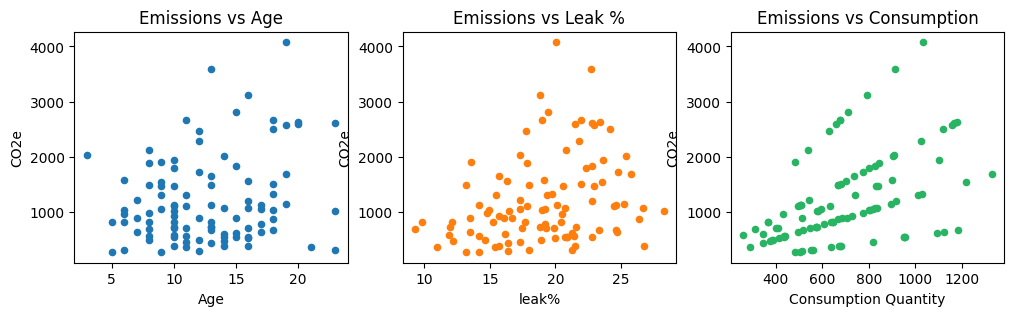

In [9]:
import matplotlib.pyplot as plt

## Emissions vs Age
data.plot("Age", "CO2e", kind="scatter", figsize=(12,3), title="Emissions vs Age", ax=plt.subplot(131), color='tab:blue')

## Emissions vs Leak %
data.plot("leak%", "CO2e", kind="scatter", figsize=(12,3), title="Emissions vs Leak %", ax=plt.subplot(132), color='tab:orange')

## Emissions vs Consumption Quantity
data.plot("Consumption Quantity", "CO2e", kind="scatter", figsize=(12,3), title="Emissions vs Consumption", ax=plt.subplot(133), color='#28b463')


From these scatter plots plots, we can observe a few insights:
   - A strong correlation between emission and consumption.
   - A weak or no correlation of emission with Age and Leak%.
   - Emission vs consumption appears to be made up of different lines.
  
  
Another way to look at the data is to use ```seaborn-pairplot```. This plot type is widely used in data analysis and provides useful insights across different features by providing a convenient way to look at both correlation and distribution of the available data. We can also apply the best fit line to the scatter plots.


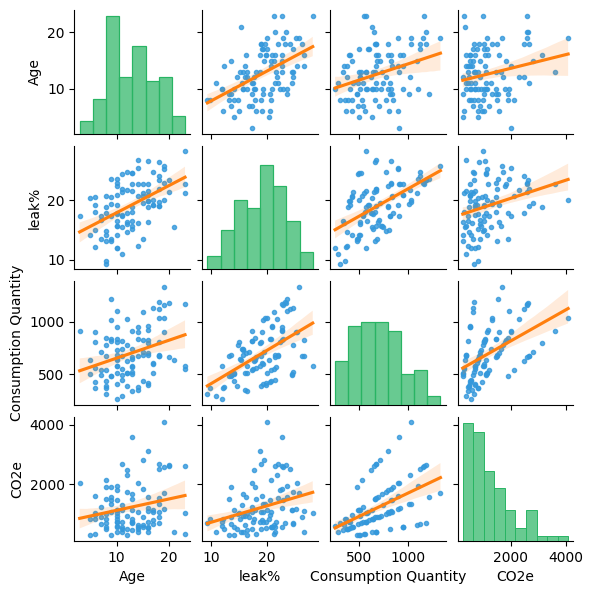

In [10]:
import seaborn as sns

sns.pairplot(data[["Age", "leak%", "Consumption Quantity", "CO2e"]], 
             kind='reg', 
             height=1.5, 
             plot_kws={'line_kws':{'color':'tab:orange'}, 'marker':'.', 'color':'#3498db'},
             diag_kws={'color':'#28b463', 'edgecolor':'#28b463', 'alpha':0.7})

The sns-pairplot with the best fit line provides a lot more insights:
- The positive slope of best fit line shows correlation between leak% and emissions. This insight was not clear from the plain scatter plot.
- A small correlation between age and emissions can also be observed.
- A high correlation between leak% and consumption is seen. Intuitively, a higher leak value should result in higher consumption.
- We can also observe a positive slope in leak% vs age plot which suggests that older assets might have higher leakage.
- The histogram in the diagonal plane of the diagram provides the distribution of different features, for example, most of the assets are approximately 10 years old.

These insights are quite useful when you select features for a model.

In analyzing the data this far, it might be that the type of refrigerant used has an impact on the quantity of emission. Let's segregate the data by the refrigerant, which is commodity_type, to test this assumption:

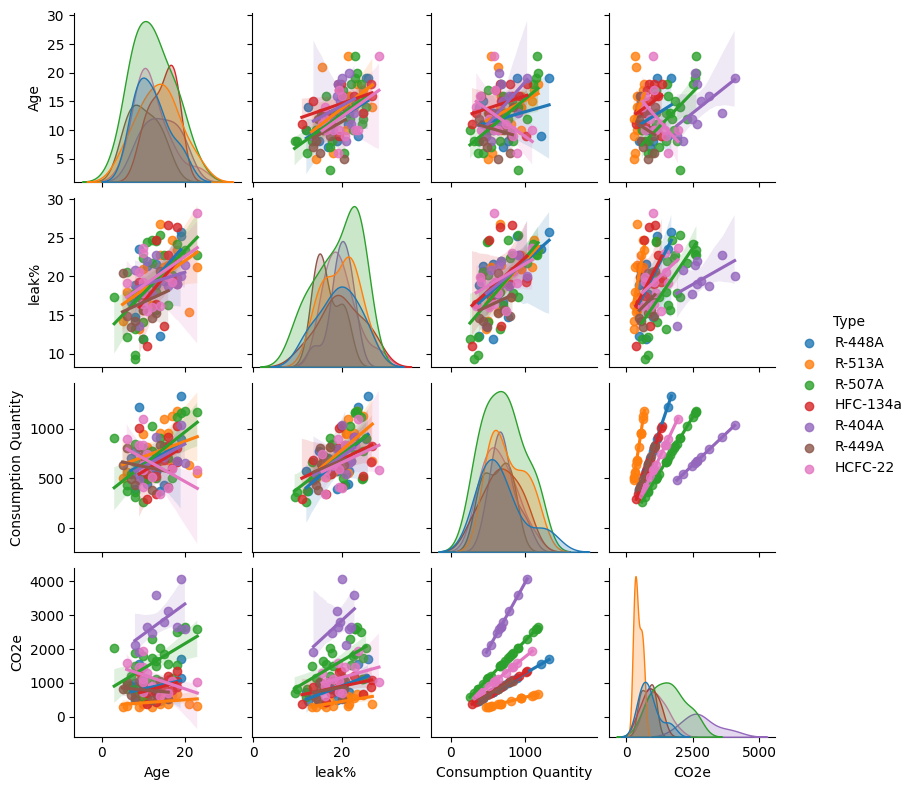

In [11]:
## segregate the data by the refrigerant(commodity_type)
sns.pairplot(data[["Age", "leak%", "Consumption Quantity", "Type", "CO2e"]], 
             kind='reg', 
             height=2, 
             # diag_kind="hist", 
             hue="Type")


These plots indicate that the assumption is correct. The type of refrigerant has an impact on the quantity of emission.

- The refrigerant R-404A, which is indicated in purple, has the highest slope compared to the other types which means the highest emission per unit of refrigerant used.
- Phasing out R-404A units and replacing them with R-513A units, which are indicated in orange, or HFC-132A units, which are indicated in red, can reduce the overall CO2 Emissions of the organization.

## Related Links


[GHG Emissions API Developer Guide](https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API)